In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5


Cloning into 'yolov5'...
remote: Enumerating objects: 17018, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 17018 (delta 120), reused 124 (delta 68), pack-reused 16805 (from 1)
Receiving objects: 100% (17018/17018), 15.73 MiB | 14.45 MiB/s, done.
Resolving deltas: 100% (11658/11658), done.
/content/yolov5


In [2]:
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 22.9 MB/s eta 0:00:00
Setup complete. Using torch 2.4.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [3]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00


In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="47QmI6P6A92eipzqfdLd")
project = rf.workspace("projects-r9lz7").project("tennis_ball_detection-0u8i1")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Tennis_ball_detection-1 in yolov5pytorch:: 100%|██████████| 2128/2128 [00:00<00:00, 7772.17it/s]


In [5]:
%pwd

'/content/yolov5'

In [6]:
dataset.location

'/content/yolov5/Tennis_ball_detection-1'

In [7]:
%cat {dataset.location}/data.yaml


names:
- ball
nc: 1
roboflow:
  license: CC BY 4.0
  project: tennis_ball_detection-0u8i1
  url: https://universe.roboflow.com/projects-r9lz7/tennis_ball_detection-0u8i1/dataset/1
  version: 1
  workspace: projects-r9lz7
test: ../test/images
train: Tennis_ball_detection-1/train/images
val: Tennis_ball_detection-1/valid/images


In [8]:
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [9]:
num_classes

'1'

In [10]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml


# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4],

In [11]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [12]:
# Ultralytics YOLOv5 🚀, AGPL-3.0 license
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# Parameters
nc: {num_classes} # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]


In [13]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 50 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache


Streaming output truncated to the last 5000 lines.
 13                -1  1    361984  models.common.C3                        [512, 256, 1, False]          
 14                -1  1     33024  models.common.Conv                      [256, 128, 1, 1]              
 15                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 16           [-1, 4]  1         0  models.common.Concat                    [1]                           
 17                -1  1     90880  models.common.C3                        [256, 128, 1, False]          
 18                -1  1    147712  models.common.Conv                      [128, 128, 3, 2]              
 19          [-1, 14]  1         0  models.common.Concat                    [1]                           
 20                -1  1    296448  models.common.C3                        [256, 256, 1, False]          
 21                -1  1    590336  models.common.Conv                      [256, 256, 3, 2] 

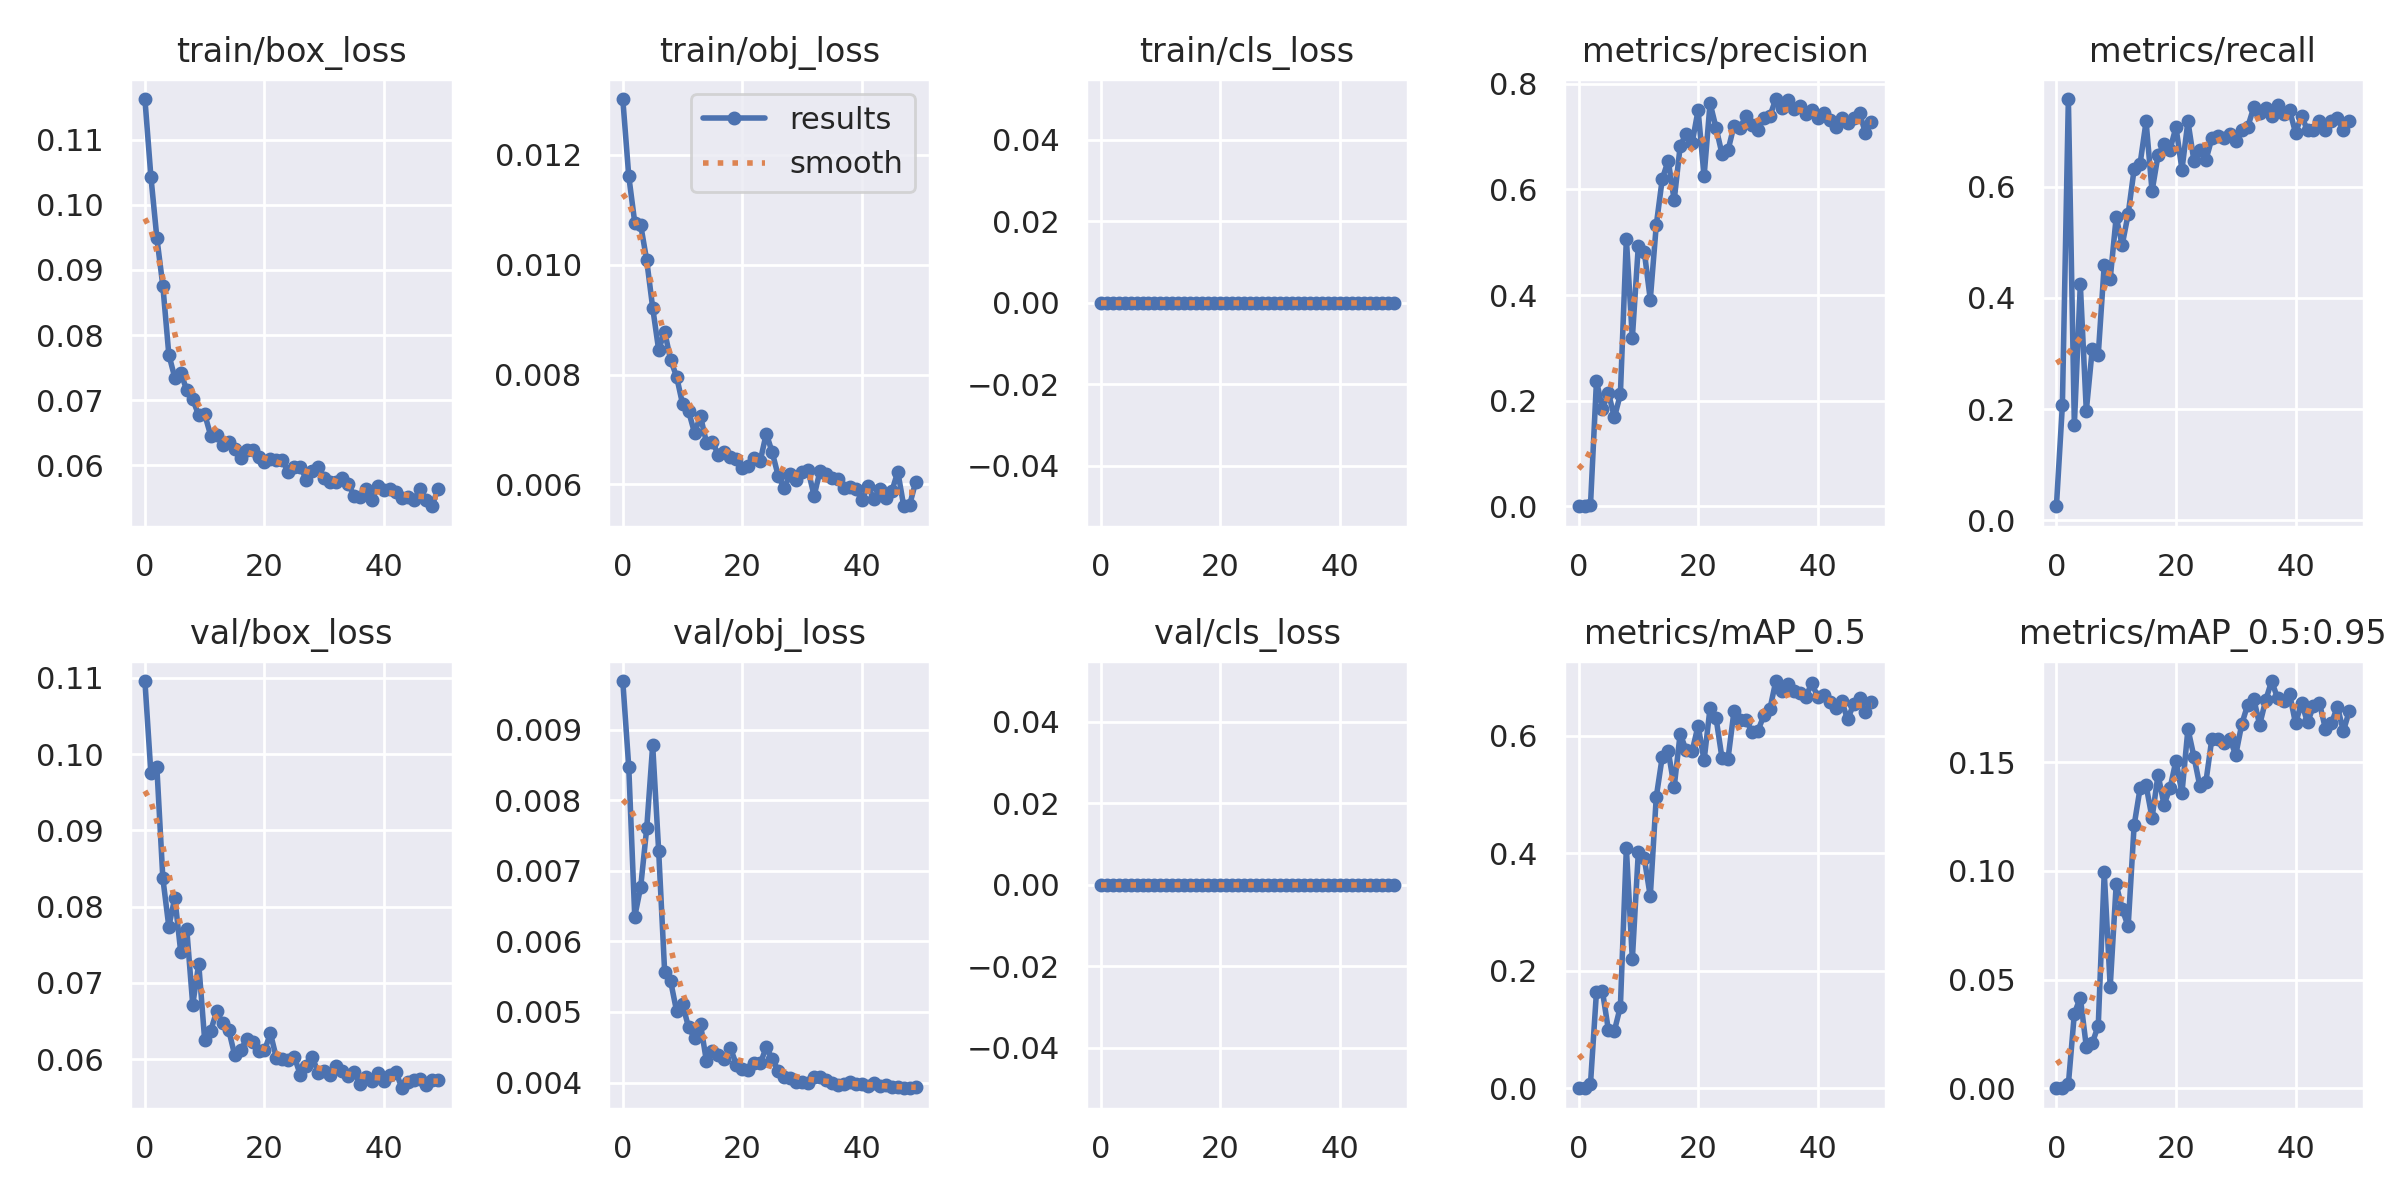

In [14]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png


In [16]:
%ls runs/


train/


In [17]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [18]:
from google.colab import files
uploaded = files.upload()

Saving WhatsApp Video 2024-10-19 at 15.52.48_da4aad4b.mp4 to WhatsApp Video 2024-10-19 at 15.52.48_da4aad4b.mp4


In [19]:
import os

# List the files in the current directory
print(os.listdir())

['detect.py', 'val.py', 'train.py', 'CONTRIBUTING.md', 'README.md', 'segment', 'requirements.txt', '__pycache__', '.gitignore', 'classify', 'export.py', 'data', 'CITATION.cff', 'utils', '.git', '.dockerignore', 'WhatsApp Video 2024-10-19 at 15.52.48_da4aad4b.mp4', 'benchmarks.py', 'Tennis_ball_detection-1', 'README.zh-CN.md', 'hubconf.py', '.github', 'pyproject.toml', 'tutorial.ipynb', 'yolov5s.pt', 'models', 'LICENSE', '.gitattributes', 'runs']


In [22]:
!ls /content/yolov5/


 benchmarks.py	   LICENSE	      segment
 CITATION.cff	   models	      Tennis_ball_detection-1
 classify	   __pycache__	      train.py
 CONTRIBUTING.md   pyproject.toml     tutorial.ipynb
 data		   README.md	      utils
 detect.py	   README.zh-CN.md    val.py
 export.py	   requirements.txt  'WhatsApp Video 2024-10-19 at 15.52.48_da4aad4b.mp4'
 hubconf.py	   runs		      yolov5s.pt


In [23]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source "/content/yolov5/WhatsApp Video 2024-10-19 at 15.52.48_da4aad4b.mp4"


/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=/content/yolov5/WhatsApp Video 2024-10-19 at 15.52.48_da4aad4b.mp4, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-377-g24ee2801 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/1319) /content/yolov5/WhatsApp Video 2024-10-19 at 15.52.48_da4aad4b.mp4: 416x256 (no detections), 27.7ms
video 1/1 (2/1319) /content/yolov5/WhatsApp Video 2024-10-19 at 15.52.48_da4aad4b.mp4: 416x256 (no detections), 

In [24]:
from google.colab import files
uploaded = files.upload()

Saving WhatsApp Video 2024-10-19 at 21.46.36_ff4382af.mp4 to WhatsApp Video 2024-10-19 at 21.46.36_ff4382af.mp4


In [25]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source "/content/yolov5/WhatsApp Video 2024-10-19 at 21.46.36_ff4382af.mp4"


/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=/content/yolov5/WhatsApp Video 2024-10-19 at 21.46.36_ff4382af.mp4, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-377-g24ee2801 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/629) /content/yolov5/WhatsApp Video 2024-10-19 at 21.46.36_ff4382af.mp4: 416x256 1 ball, 27.0ms
video 1/1 (2/629) /content/yolov5/WhatsApp Video 2024-10-19 at 21.46.36_ff4382af.mp4: 416x256 1 ball, 6.1ms
video 1/1 (3/6

In [26]:
!ls runs/detect


exp  exp2  exp3  exp4
